In [15]:
import deblend
import om10
import desc.slrealizer
import warnings
warnings.filterwarnings("ignore")

In [16]:
db = om10.DB()
db.select_random(maglim=23.3,area=18000.0,IQ=0.75)
db.paint(synthetic=True)
realizer = desc.slrealizer.SLRealizer(catalog=db, observation="../../../data/twinkles_observation_history.csv")

OM10: Full db.lenses table contains 15658 systems
OM10: Initial db.sample contains 15658 systems
OM10: selection yields 2813 lenses


In [17]:
%matplotlib inline
%pylab inline
matplotlib.use('TkAgg')
matplotlib.rc('text', usetex=False)

Populating the interactive namespace from numpy and matplotlib


In [18]:
# Choose a good lens system, with large imsep and 4 images:
                      
wide = db.sample[np.where(db.sample['IMSEP'] > 1.0)]
print "Number of lenses with image separation > 1.0 arcsec = ",len(wide)

wide_quads = wide[np.where(wide['NIMG'] == 4)]
print "Number of these with 4 images = ",len(wide_quads)

bright_wide_quads = wide[np.where(wide_quads['MAGI'] < 22)]
print "Number of these with i3 < 22 = ",len(bright_wide_quads)

db.sample = bright_wide_quads    
                      
k = db.sample[0]['LENSID']

Number of lenses with image separation > 1.0 arcsec =  1911
Number of these with 4 images =  249
Number of these with i3 < 22 =  129


In [19]:
realizer.test_covariance_matrix(lensID=k)

[60549.280376999995 'i' 0.928414 23.455802]
OM10: Extracted OM10 lens number 1262389:
 LENSID FLAGTYPE NIMG ZLENS ... i_SDSS_quasar z_SDSS_quasar u_SDSS_quasar
------- -------- ---- ----- ... ------------- ------------- -------------
1262389        0    2 0.292 ...         20.37  20.259088619 21.4602876516
 LENSID FLAGTYPE NIMG ZLENS ... i_SDSS_quasar z_SDSS_quasar u_SDSS_quasar
------- -------- ---- ----- ... ------------- ------------- -------------
1262389        0    2 0.292 ...         20.37  20.259088619 21.4602876516
OM10: Extracted OM10 lens number 1262389:
 LENSID FLAGTYPE NIMG ZLENS ... i_SDSS_quasar z_SDSS_quasar u_SDSS_quasar
------- -------- ---- ----- ... ------------- ------------- -------------
1262389        0    2 0.292 ...         20.37  20.259088619 21.4602876516
('total_second_moment: ', (0.39423165702193674, 1.7718668634924877))
*******************************
OM10: Extracted OM10 lens number 1262389:
 LENSID FLAGTYPE NIMG ZLENS ... i_SDSS_quasar z_SDSS_quasar u_S

OM10: Extracted OM10 lens number 1262389:
 LENSID FLAGTYPE NIMG ZLENS ... i_SDSS_quasar z_SDSS_quasar u_SDSS_quasar
------- -------- ---- ----- ... ------------- ------------- -------------
1262389        0    2 0.292 ...         20.37  20.259088619 21.4602876516
calculating images zeroth moment
0.000203306546658
9.8049969487e-06
[[ 0.38409563  0.75396331]
 [ 0.75396331  1.50299076]]
OM10: Extracted OM10 lens number 1262389:
 LENSID FLAGTYPE NIMG ZLENS ... i_SDSS_quasar z_SDSS_quasar u_SDSS_quasar
------- -------- ---- ----- ... ------------- ------------- -------------
1262389        0    2 0.292 ...         20.37  20.259088619 21.4602876516
calculating images zeroth moment
0.000203306546658
9.8049969487e-06
x_center_of_mass: 0.758090282444 y_center_of_mass:  0.754057119029
calculating images zeroth moment
0.000203306546658
9.8049969487e-06
[[ 0.38409563  0.75396331]
 [ 0.75396331  1.50299076]]
covariance matrix:  [[ 0.38409563  0.75396331]
 [ 0.75396331  1.50299076]]
total_zeroth_mom

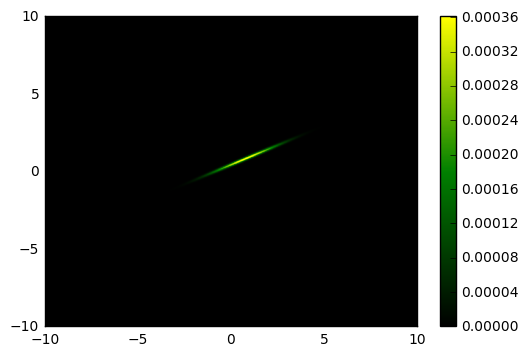

OM10: Extracted OM10 lens number 1262389:
 LENSID FLAGTYPE NIMG ZLENS ... i_SDSS_quasar z_SDSS_quasar u_SDSS_quasar
------- -------- ---- ----- ... ------------- ------------- -------------
1262389        0    2 0.292 ...         20.37  20.259088619 21.4602876516


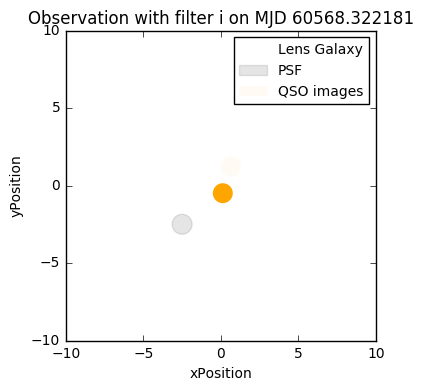

In [20]:
realizer.deblend(lensID=k, null_deblend=True, debug=False)

OM10: Extracted OM10 lens number 1262389:
 LENSID FLAGTYPE NIMG ZLENS ... i_SDSS_quasar z_SDSS_quasar u_SDSS_quasar
------- -------- ---- ----- ... ------------- ------------- -------------
1262389        0    2 0.292 ...         20.37  20.259088619 21.4602876516
calculating images zeroth moment
0.000203306546658
9.8049969487e-06
[[ 0.38409563  0.75396331]
 [ 0.75396331  1.50299076]]
OM10: Extracted OM10 lens number 1262389:
 LENSID FLAGTYPE NIMG ZLENS ... i_SDSS_quasar z_SDSS_quasar u_SDSS_quasar
------- -------- ---- ----- ... ------------- ------------- -------------
1262389        0    2 0.292 ...         20.37  20.259088619 21.4602876516
galaxy_x, galaxy_y, PSF_HWHM:
multiplication factor :  8.70690267976e-12
0.000203306546658
PSF_sigma:  0.321158298952
multiplication factor :  0.000203306546658
9.8049969487e-06
PSF_sigma:  0.321158298952
multiplication factor :  9.8049969487e-06


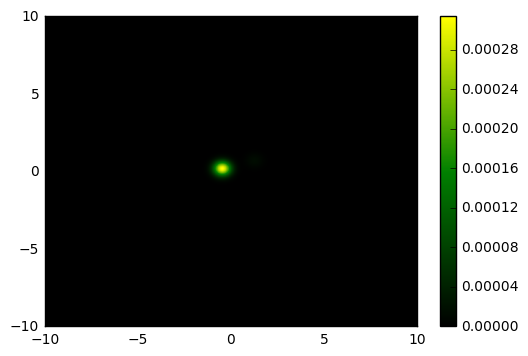

OM10: Extracted OM10 lens number 1262389:
 LENSID FLAGTYPE NIMG ZLENS ... i_SDSS_quasar z_SDSS_quasar u_SDSS_quasar
------- -------- ---- ----- ... ------------- ------------- -------------
1262389        0    2 0.292 ...         20.37  20.259088619 21.4602876516


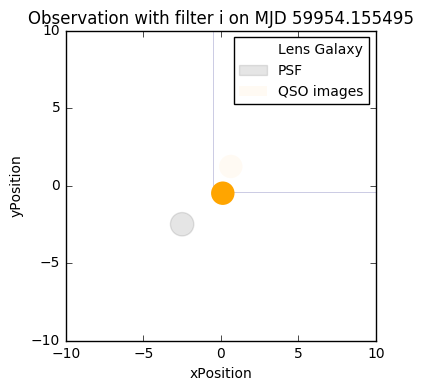

In [21]:
realizer.deblend(lensID=k, null_deblend=False, debug=True)

OM10: Extracted OM10 lens number 1262389:
 LENSID FLAGTYPE NIMG ZLENS ... i_SDSS_quasar z_SDSS_quasar u_SDSS_quasar
------- -------- ---- ----- ... ------------- ------------- -------------
1262389        0    2 0.292 ...         20.37  20.259088619 21.4602876516
calculating images zeroth moment
0.000203306546658
9.8049969487e-06
x_center_of_mass: 0.758090295775 y_center_of_mass:  0.754057132289
calculating images zeroth moment
0.000203306546658
9.8049969487e-06
[[ 0.38409564  0.75396333]
 [ 0.75396333  1.50299081]]
covariance matrix:  [[ 0.38409564  0.75396333]
 [ 0.75396333  1.50299081]]
total_zeroth_moment :  0.000213111548566


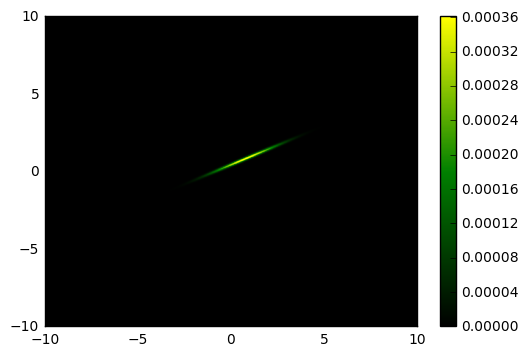

OM10: Extracted OM10 lens number 1262389:
 LENSID FLAGTYPE NIMG ZLENS ... i_SDSS_quasar z_SDSS_quasar u_SDSS_quasar
------- -------- ---- ----- ... ------------- ------------- -------------
1262389        0    2 0.292 ...         20.37  20.259088619 21.4602876516
galaxy_x, galaxy_y, PSF_HWHM:
multiplication factor :  4.95918223901e-12
0.000203306546658
PSF_sigma:  0.520166711925
multiplication factor :  0.000203306546658
9.8049969487e-06
PSF_sigma:  0.520166711925
multiplication factor :  9.8049969487e-06


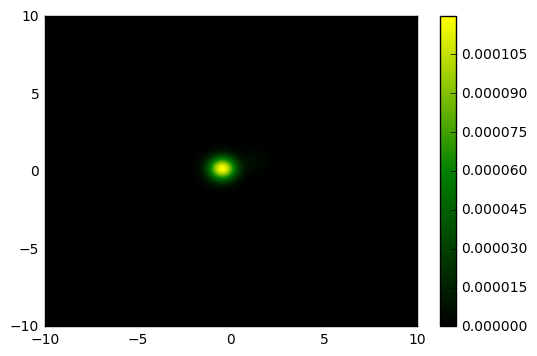

('Chi squared distance is : ', Power_divergenceResult(statistic=1.8709549605064227e+56, pvalue=0.0))
('KL distance is : ', 3.486929350338603)


In [22]:
realizer.deblend_distance(lensID=k, null_deblend=True, debug=True, show_plot=True)

### Below is the code that I should eventually delete

OM10: Extracted OM10 lens number 1262389:
 LENSID FLAGTYPE NIMG ZLENS ... i_SDSS_quasar z_SDSS_quasar u_SDSS_quasar
------- -------- ---- ----- ... ------------- ------------- -------------
1262389        0    2 0.292 ...         20.37  20.259088619 21.4602876516
calculating images zeroth moment
0.000203306546658
9.8049969487e-06
[[ 0.38409564  0.75396333]
 [ 0.75396333  1.50299081]]
OM10: Extracted OM10 lens number 1262389:
 LENSID FLAGTYPE NIMG ZLENS ... i_SDSS_quasar z_SDSS_quasar u_SDSS_quasar
------- -------- ---- ----- ... ------------- ------------- -------------
1262389        0    2 0.292 ...         20.37  20.259088619 21.4602876516
galaxy_x, galaxy_y, PSF_HWHM:
multiplication factor :  4.95918223901e-12
0.000203306546658
PSF_sigma:  0.44801172906
multiplication factor :  0.000203306546658
9.8049969487e-06
PSF_sigma:  0.44801172906
multiplication factor :  9.8049969487e-06


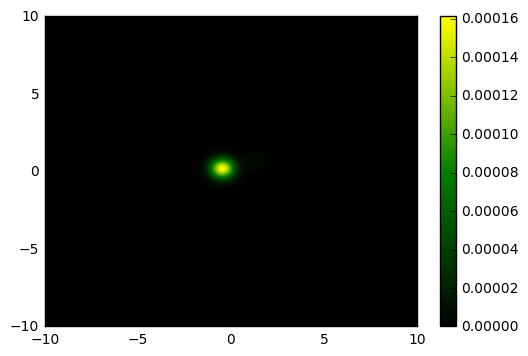

OM10: Extracted OM10 lens number 1262389:
 LENSID FLAGTYPE NIMG ZLENS ... i_SDSS_quasar z_SDSS_quasar u_SDSS_quasar
------- -------- ---- ----- ... ------------- ------------- -------------
1262389        0    2 0.292 ...         20.37  20.259088619 21.4602876516


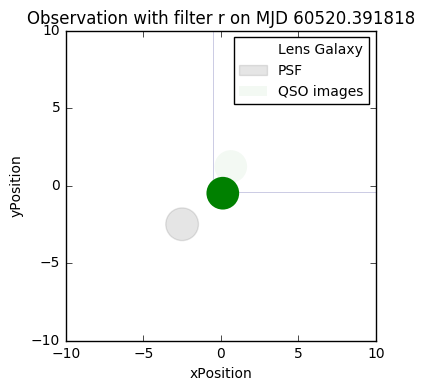

In [23]:
realizer.deblend(lensID=k, null_deblend=False, debug=True)

OM10: Extracted OM10 lens number 1262389:
 LENSID FLAGTYPE NIMG ZLENS ... i_SDSS_quasar z_SDSS_quasar u_SDSS_quasar
------- -------- ---- ----- ... ------------- ------------- -------------
1262389        0    2 0.292 ...         20.37  20.259088619 21.4602876516


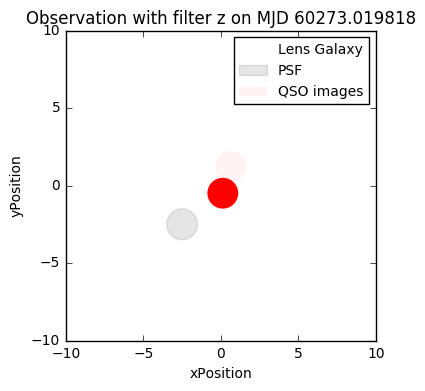

In [24]:
realizer.plot_lens_random_date(lensID=k)

Populating the interactive namespace from numpy and matplotlib
[[3, 1], [2, 2], [1, 1]]


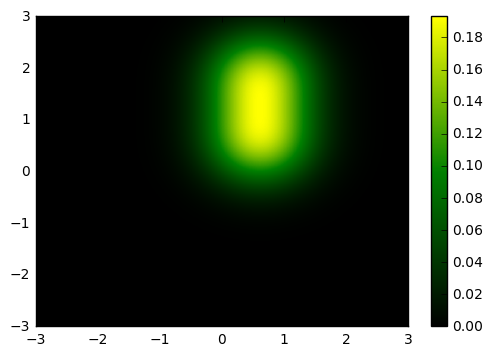

In [25]:
#deblender sample
from scipy.stats import multivariate_normal
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import scipy
import scipy.optimize as opt
%matplotlib inline
%pylab inline
matplotlib.use('TkAgg')
matplotlib.rc('text', usetex=False)

number_of_rows = 1000
number_of_columns = 1000
image = [[0]*number_of_rows for _ in range(number_of_columns)]
image1 = [[0]*number_of_rows for _ in range(number_of_columns)]

x, y = np.mgrid[-5:5:.01, -5:5:.01]
pos = np.dstack((x, y))

init_guess = []

init_guess.append([3, 1])
init_guess.append([2, 2])
init_guess.append([1, 1])

init_guess_sigma = []


print init_guess

rv = scipy.stats.multivariate_normal([3, 1]) # xPos, yPos, covariance matrix whose entrees are just FWHM
#print rv
image = image + rv.pdf(pos) # BUG: multiply flux ratio
# save peak value
#rv = scipy.stats.multivariate_normal([2, 2])
#image = image + rv.pdf(pos)
rv = scipy.stats.multivariate_normal([1, 1])
image = image + rv.pdf(pos)
#print image # this is a 2d array
#print image

cmap2 = matplotlib.colors.LinearSegmentedColormap.from_list('my_colormap', ['black', 'green', 'yellow'], 256)
img2 = plt.imshow(image, interpolation='nearest', cmap = cmap2, origin='lower', extent=[-3, 3, -3, 3], aspect = "auto")

plt.colorbar(img2,cmap=cmap2)
plt.show()

def twoD_Gaussian((x, y), amplitude, xo, yo, sigma_x, sigma_y, theta, offset):
    xo = float(xo)
    yo = float(yo)    
    a = (np.cos(theta)**2)/(2*sigma_x**2) + (np.sin(theta)**2)/(2*sigma_y**2)
    b = -(np.sin(2*theta))/(4*sigma_x**2) + (np.sin(2*theta))/(4*sigma_y**2)
    c = (np.sin(theta)**2)/(2*sigma_x**2) + (np.cos(theta)**2)/(2*sigma_y**2)
    g = offset + amplitude*np.exp( - (a*((x-xo)**2) + 2*b*(x-xo)*(y-yo) 
                            + c*((y-yo)**2)))
    return g

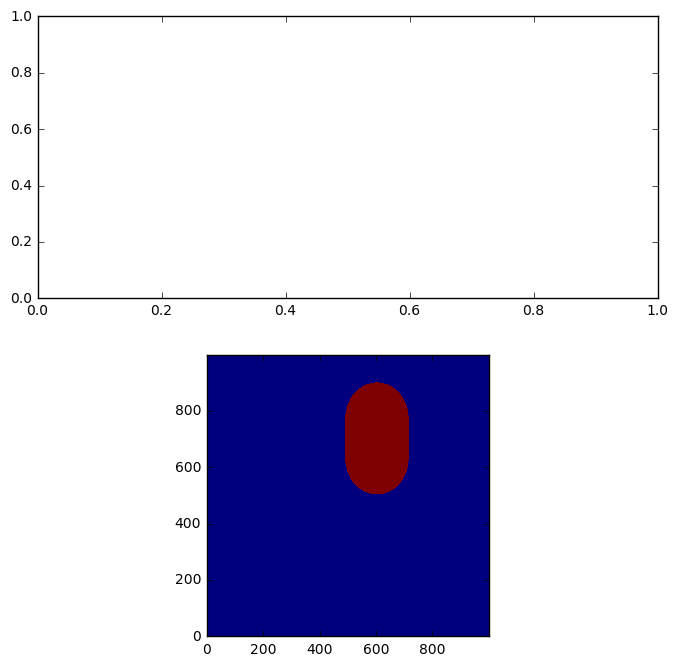

In [26]:
import photutils
segm = photutils.detect_sources(image, 0.1, 3)
# plot the image and the segmentation image
import matplotlib.pyplot as plt
numpy.set_printoptions(threshold='nan')
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 8))
ax2.imshow(segm.data, origin='lower', interpolation='nearest')
#print segm.data

#segm_deblend = photutils.segmentation.deblend_sources(image, segm.data, 4)
#plt.imshow(segm_deblend.data, origin='lower', interpolation='nearest')

 id xcentroid   ycentroid   ...      peak           flux          mag      
--- --------- ------------- ... -------------- ------------- --------------
  1     600.0 600.003179014 ... 0.180694222394 2.57373457617 -1.02640939251
  2     600.0 799.996820986 ... 0.180694222394 2.57373457617 -1.02640939251


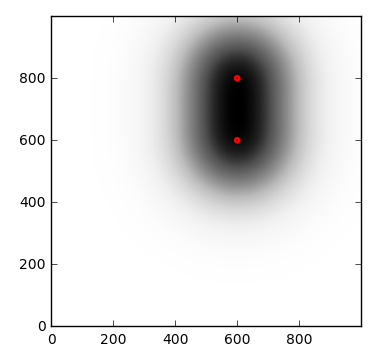

In [27]:
from photutils import DAOStarFinder

daofind = DAOStarFinder(fwhm=1.5, threshold=0.00001)
sources = daofind(image)
print sources

from astropy.visualization import SqrtStretch
from astropy.visualization.mpl_normalize import ImageNormalize
from photutils import CircularAperture
positions = (sources['xcentroid'], sources['ycentroid'])
apertures = CircularAperture(positions, r=4.)
norm = ImageNormalize(stretch=SqrtStretch())
plt.imshow(image, cmap='Greys', origin='lower', norm=norm)
apertures.plot(color='red', lw=3.0, alpha=1.0)

#from astropy.visualization import SqrtStretch
#from astropy.visualization.mpl_normalize import ImageNormalize
#from photutils import CircularAperture

#positions = (sources['xcentroid'], sources['ycentroid'])
#apertures = CircularAperture(positions, r=500)
#norm = ImageNormalize(stretch=SqrtStretch())
#img2 = plt.imshow(image, interpolation='nearest', cmap = cmap2, origin='lower', extent=[-3, 3, -3, 3], aspect = "auto")
#apertures.plot(color='white', lw=10, alpha=1)

In [28]:
#deblend fit gaussian
#pick peaks out and then start fitting
#https://stackoverflow.com/questions/21566379/fitting-a-2d-gaussian-function-using-scipy-optimize-curve-fit-valueerror-and-m